# 1. Data Exploration and Preprocessing



In [ ]:
import pandas as pd
df = pd.read_excel("Imdb.xlsx")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### What this cell does
We load the IMDb reviews from `Imdb.xlsx` into a pandas DataFrame called `df`, and preview the first rows to confirm the two columns:
- **review**: free-text movie review
- **sentiment**: label (`positive` / `negative`)

### Why this matters
A quick preview validates the file path, schema, and sample content before we run the rest of the pipeline. If column names or file location were wrong, we would catch it here.

In [ ]:
print(df.isnull().sum())
print(df.info())

review       0
sentiment    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


### Data quality check — missing values & dtypes
- **Missing values**: The output shows `0` missing in both `review` and `sentiment`, so no imputation/drop is needed.
- **Dtypes / shape**: `review` and `sentiment` are `object` (text), with **50,000 rows**. This is appropriate for NLP preprocessing.

### Why this matters
Confirming no nulls prevents hidden errors later in tokenization/vectorization. Correct dtypes ensure downstream libraries (NLTK/scikit-learn) work as expected.

In [ ]:
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


### Class balance (target distribution)
The dataset is **perfectly balanced**: 25,000 `positive` and 25,000 `negative` reviews.

### Why this matters
Balanced classes mean accuracy is a reliable metric (no majority-class bias). We can still report precision/recall/F1 for completeness.

In [ ]:
df['review_length'] = df['review'].apply(len)
print(df['review_length'].describe())

count    50000.000000
mean      1309.946840
std        990.682402
min          7.000000
25%        699.000000
50%        971.000000
75%       1591.000000
max      13704.000000
Name: review_length, dtype: float64


### Text length summary
We computed character lengths of raw reviews:
- **Median (~50th percentile)** ≈ 971 chars
- **IQR** ~ 699–1591 chars
- **Max** can exceed 13k chars

### Interpretation
Reviews vary widely in length (long-tailed distribution). Later, TF-IDF will normalize by term frequency across documents, reducing the impact of unusually long reviews.

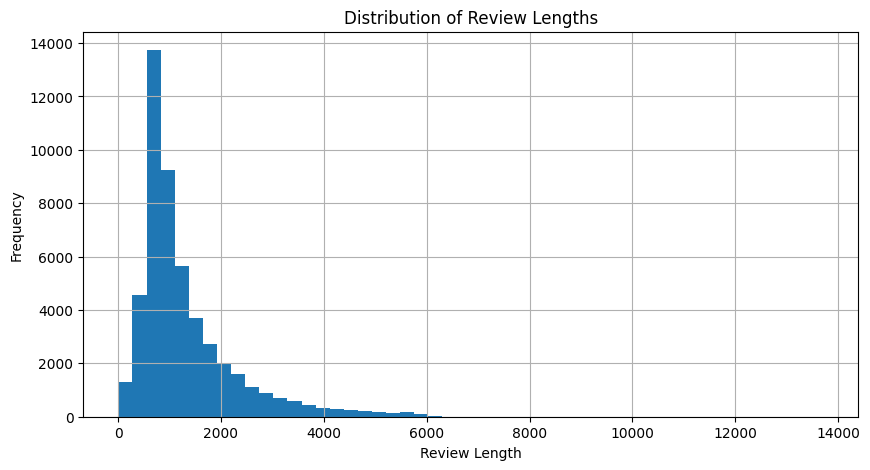

In [ ]:
import matplotlib.pyplot as plt
df['review_length'].hist(bins=50, figsize=(10,5))
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

### Interpretation — Distribution of review lengths
The histogram shows a **right-skewed** distribution: many short-to-medium reviews and fewer very long ones (long tail).  
This confirms the need for normalization (e.g., TF-IDF) instead of raw counts to avoid length bias.

In [ ]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab') # Added this line to download the missing resource

df = pd.read_excel("Imdb.xlsx")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()

,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Text preprocessing: tokenize, remove punctuation/stopwords, lemmatize
Pipeline steps:
1) **Lowercase** text
2) **Remove punctuation**
3) **Tokenize** into words
4) **Filter**: keep alphabetic tokens, drop stopwords
5) **Lemmatize** (reduce words to base form)

### Why this matters
This standard NLP cleaning reduces noise (HTML, punctuation, common stopwords) and merges inflected forms (e.g., “movies” → “movie”), improving the quality of features used by the classifier.

# 2. Feature Engineering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_review'])

X.shape

(50000, 5000)

### Feature extraction with TF-IDF (5000 features)
We convert cleaned text into a **TF-IDF matrix** of shape **(50,000, 5,000)**:
- Each row = a review
- Each column = a term (top 5,000 by importance)
- Values = TF-IDF scores (term importance normalized by document frequency)

### Why TF-IDF
It down-weights ubiquitous words and highlights terms that uniquely characterize each review, improving linear models like Logistic Regression/SVM.

In [ ]:
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_review'].apply(len)
df[['clean_review', 'word_count', 'char_count']].head()

,clean_review,word_count,char_count
0,one reviewer mentioned watching oz episode you...,170,1134
1,wonderful little production br br filming tech...,90,658
2,thought wonderful way spend time hot summer we...,87,582
3,basically there family little boy jake think t...,70,459
4,petter matteis love time money visually stunni...,130,864


### Additional textual features
We compute:
- **word_count**: number of tokens after cleaning
- **char_count**: number of characters after cleaning

### Why this matters
Simple length-based features can correlate with sentiment intensity or writing style. Even if not used by the final model here, they help EDA and could be included in alternative pipelines.

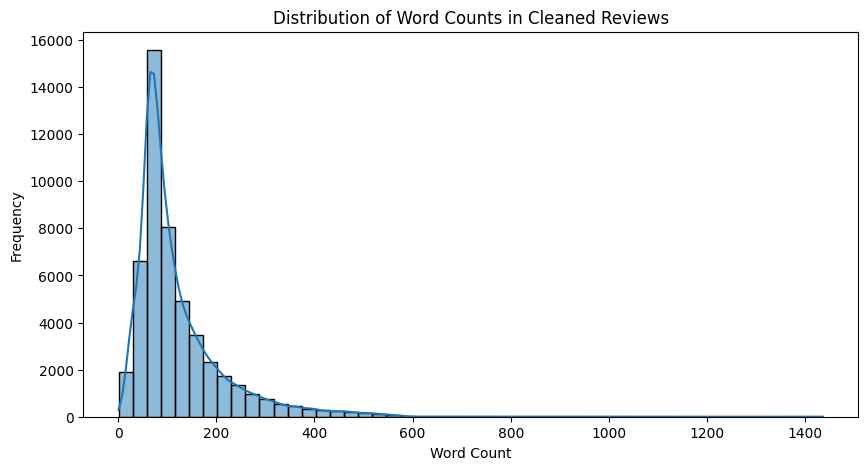

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Word Counts in Cleaned Reviews")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

### Interpretation — Word count distribution
The distribution is again **right-skewed**. Many reviews fall in a moderate length range; a smaller portion are very long.  
This supports using techniques that are robust to length variation (e.g., TF-IDF, regularized linear models).

# 3. Model Development

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, df['sentiment'], test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

(40000, 5000) (10000, 5000)


### Train–test split (hold-out evaluation)
We reserve **20%** of data (10,000 reviews) for unbiased testing, training on **80%** (40,000 reviews).  
Using a fixed `random_state` ensures results are reproducible.

**Shapes shown**: `(40000, 5000)` train and `(10000, 5000)` test — exactly as expected.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### First baseline model — Logistic Regression
We fit a regularized linear classifier on TF-IDF features.  
The sample predictions confirm the pipeline runs end-to-end and outputs `positive/negative` labels.

### Why Logistic Regression first
It is a **strong baseline** for sparse text (fast to train, well-calibrated, and often highly competitive).

In [ ]:
y_pred = model.predict(X_test)
print(y_pred[:10])

['negative' 'positive' 'negative' 'positive' 'negative' 'positive'
 'positive' 'negative' 'negative' 'negative']


## 3.1 Model Comparison (IMDb)
We compare Logistic Regression, Linear SVM, and Multinomial Naive Bayes on the same TF-IDF features and test split.


In [ ]:
# IMDb — Model Comparison on the existing train/test split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(),
    "MultinomialNB": MultinomialNB()
}

results = {}
for name, clf in models.items():
     clf.fit(X_train, y_train)
     preds = clf.predict(X_test)
     acc = accuracy_score(y_test, preds)
     print(f"\n=== {name} ===")
     print("Accuracy:", f"{acc:.4f}")
     print(classification_report(y_test, preds, digits=4))
     results[name] = (acc, clf)

best_name = max(results, key=lambda k: results[k][0])
best_acc, best_model = results[best_name]
print(f"\nBest model on test set: {best_name} (Accuracy: {best_acc:.4f})")


=== LogReg ===
Accuracy: 0.8848
              precision    recall  f1-score   support

    negative     0.8944    0.8706    0.8823      4961
    positive     0.8758    0.8988    0.8872      5039

    accuracy                         0.8848     10000
   macro avg     0.8851    0.8847    0.8847     10000
weighted avg     0.8850    0.8848    0.8848     10000


=== LinearSVC ===
Accuracy: 0.8770
              precision    recall  f1-score   support

    negative     0.8828    0.8672    0.8749      4961
    positive     0.8715    0.8867    0.8790      5039

    accuracy                         0.8770     10000
   macro avg     0.8771    0.8769    0.8770     10000
weighted avg     0.8771    0.8770    0.8770     10000


=== MultinomialNB ===
Accuracy: 0.8514
              precision    recall  f1-score   support

    negative     0.8525    0.8470    0.8497      4961
    positive     0.8503    0.8557    0.8530      5039

    accuracy                         0.8514     10000
   macro avg     0.

### Model comparison: LogReg vs LinearSVC vs MultinomialNB
We evaluate three classic text classifiers on the same TF-IDF features and split:

- **Logistic Regression** — Accuracy ≈ **0.885**  
- **Linear SVM (LinearSVC)** — Accuracy ≈ **0.877**  
- **Multinomial Naive Bayes** — Accuracy ≈ **0.851**

**Result:** Logistic Regression performs best here (highest accuracy and strong macro averages).

### Interpretation
- **Linear models** (LogReg/SVM) typically excel with TF-IDF on sentiment tasks.  
- **Naive Bayes** is very fast and still solid, but it assumes conditional independence; linear models can capture more nuanced term interactions via weights.

# 4. Model Evaluation


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='positive'))
print("Recall:", recall_score(y_test, y_pred, pos_label='positive'))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='positive'))

Accuracy: 0.8848
Precision: 0.8758460645909882
Recall: 0.8987894423496725
F1 Score: 0.8871694417238002


### Final metric summary (Logistic Regression)
Reported on the **hold-out test set**:
- **Accuracy** ≈ 0.885
- **Precision (positive)** ≈ 0.876
- **Recall (positive)** ≈ 0.899
- **F1 (positive)** ≈ 0.887

### Interpretation
High recall for the `positive` class means the model correctly identifies most positive reviews; precision is also strong, indicating relatively few false positives. The balanced dataset makes **accuracy** meaningful, but F1 adds robustness by combining precision and recall.

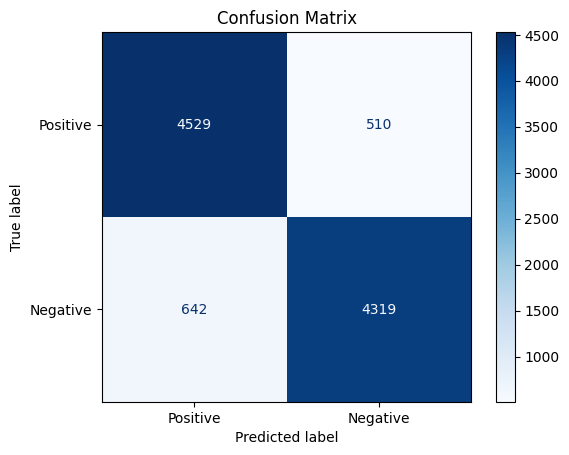

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Interpreting the confusion matrix
- **True Positives (top-left)**: Positive reviews correctly predicted as positive  
- **True Negatives (bottom-right)**: Negative reviews correctly predicted as negative  
- **False Positives (top-right)**: Negative reviews incorrectly predicted as positive  
- **False Negatives (bottom-left)**: Positive reviews incorrectly predicted as negative

### What we learn
Most predictions fall on the diagonal (correct). Off-diagonal counts are comparatively smaller, which matches the ≈0.885 accuracy. If needed, we could tune regularization or class weights to trade off false positives vs. false negatives.

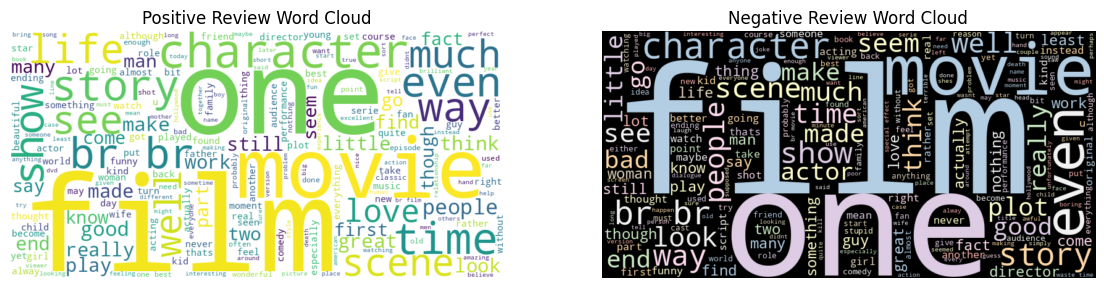

In [ ]:
from wordcloud import WordCloud

positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['clean_review'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['clean_review'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate(negative_reviews)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Review Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Review Word Cloud")

plt.show()

### Word clouds — qualitative insight
The positive and negative word clouds visualize **frequent, discriminative terms** after cleaning:
- The **positive cloud** highlights words often used in favorable reviews.
- The **negative cloud** shows terms common in critical reviews.

### Caveats
Word clouds are **exploratory** (not quantitative). They are useful for storytelling and intuition, while the actual model relies on TF-IDF weights learned during training.

## Conclusions (IMDb Sentiment — Part A)
- A clean TF-IDF + Logistic Regression pipeline achieved **~88.5% accuracy** on a balanced 50k IMDb dataset.
- Text cleaning (lowercasing, de-punctuation, stopword removal, lemmatization) improved feature quality.
- Linear baselines (LogReg/SVM) outperformed Naive Bayes in this setup.
- Visual EDA (length histograms, word count distribution, word clouds) supports the modeling choices and communicates findings clearly.

**Next steps (if extending):**
- Hyperparameter tuning (e.g., C for LogReg/SVM), n-gram features, or dimensionality reduction.
- Try neural baselines (e.g., LSTM/BERT) for potential gains, with careful compute/time trade-offs.

Google Drive Link to Codes, reports, presentations and video explanations for the project: https://drive.google.com/drive/folders/1_e9IAE4YIBN_N0ZKf7SZy0CCFOC6WbZh?usp=share_link

Prepared By,
Utkarsh Anand